# Named entity recognition

In this notebook a pretrained BERT model is finetuned to do named entity recognition based on the CONLL dataset, which already contains token level labels. Notebook based on https://huggingface.co/learn/nlp-course/chapter7/2. 

In [ ]:
# install relevant packages
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
!apt install git-lfs
!pip install seqeval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Reading package lists... Done
Building dependency tree... Done
Reading state informatio

In [ ]:
# load packages
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification
from transformers import Trainer
from transformers import TrainingArguments
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
# load training, validation and test set from the CONLL dataset
ds_train = load_dataset("conll2003", split="train")
ds_valid = load_dataset("conll2003", split="validation")
ds_test = load_dataset("conll2003", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
# extract the token level label names of the training data
ner_feature = ds_train.features["ner_tags"]
label_names = ner_feature.feature.names

In [ ]:
# load pretrained BERT model, as well as tokenizer and data collator
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# function to match labels with tokens
# special tokens get a label -100 so that they are ignored in the loss function
# fix mismatch when a word is split into multiple tokens
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

# function to tokenize all the inputs and apply align_labels_with_tokens()
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# preprocess datasets using above functions
# select only 1000 random examples to save memory and time

validation_set = ds_valid.shuffle(seed=23).select(range(1000)).map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=ds_train.column_names,
)

test_set = ds_test.shuffle(seed=23).select(range(1000)).map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=ds_train.column_names,
)

training_set = ds_train.shuffle(seed=23).select(range(1000)).map(
  tokenize_and_align_labels,
  batched=True,
  remove_columns=ds_train.column_names,
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

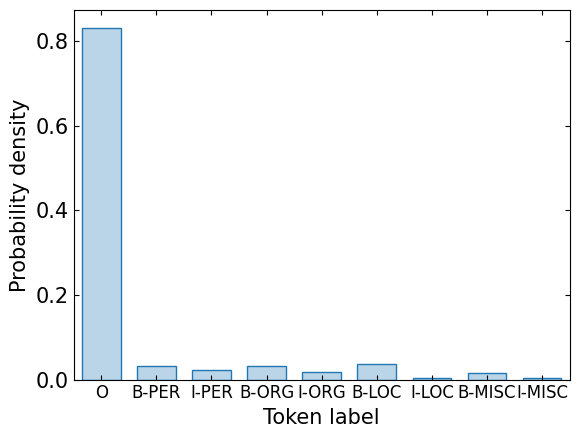

In [ ]:
# plot distribution of token labels in training data

_ = plt.hist([item for row in ds_train.shuffle(seed=23).select(range(1000))['ner_tags'] for item in row], bins=9, density=True, range=(-0.5,8.5), color=("C0", 0.3), edgecolor = "C0", rwidth=0.7)
#_ = plt.hist([item for row in ds_train.shuffle(seed=23).select(range(1000))['ner_tags'] for item in row], bins=9, density=True, range=(-0.5,8.5), histtype='step', edgecolor = "C0")
plt.tick_params(top = 1 , right = 1, which = 'both', direction = 'in', labelsize=15)
plt.ylabel('Probability density', fontsize=15)
plt.xlabel('Token label', fontsize=15)
plt.xlim([-0.5,8.5])

plt.xticks(ticks=list(id2label.keys()), labels=list(label2id.keys()), fontsize=12)

plt.savefig('ner_distribution.pdf', dpi=9600, bbox_inches = 'tight')
files.download('ner_distribution.pdf');

In [ ]:
# function to evaluate metrics for given output

metric = evaluate.load("seqeval")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [ ]:
# dictionary to transform label to numerical id
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

# load pretrained model
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# specifiy training arguments
# determined from a hyperparameter search
args = TrainingArguments(
    "bert-finetuned-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    logging_steps=1,
    num_train_epochs=4,
    weight_decay=0.01,
    push_to_hub=False,
)

# create trainer object
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=training_set.select(100),
    eval_dataset=validation_set,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
training_set

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})

In [ ]:
# train for 4 epochs
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.117000,0.165189,0.807843,0.887453,0.845779,0.964843
2,0.000800,0.197153,0.840267,0.880991,0.860147,0.968048
3,0.001300,0.173174,0.859594,0.890145,0.874603,0.968754
4,0.000400,0.179757,0.861658,0.895530,0.878268,0.969933


TrainOutput(global_step=500, training_loss=0.023587956774339544, metrics={'train_runtime': 201.0247, 'train_samples_per_second': 19.898, 'train_steps_per_second': 2.487, 'total_flos': 85886330075280.0, 'train_loss': 0.023587956774339544, 'epoch': 4.0})

In [ ]:
# determine performance on test set
model.eval()
trainer.predict(test_set).metrics['test_accuracy'], trainer.predict(test_set).metrics['test_f1']

(0.95852784713929, 0.8462647822324777)

In [ ]:
# perform training for a varying number of training samples to view how the performance increases
training_samples = [10,30,100,300,1000]

# save F1 scores and accuracy
test_results = {}
F1_scores = []
accuracy_scores = []
for num_samples in training_samples:

  print('TRAINING BERT WITH', num_samples, 'SAMPLES.\n')

  # reinitialize pretrained model
  model = AutoModelForTokenClassification.from_pretrained(
      model_checkpoint,
      id2label=id2label,
      label2id=label2id,
  )

  # create training set of specified size
  training_set = ds_train.shuffle(seed=23).select(range(num_samples)).map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=ds_train.column_names,
  )

  # finetune model
  trainer = Trainer(
      model=model,
      args=args,
      train_dataset=training_set,
      eval_dataset=validation_set,
      data_collator=data_collator,
      compute_metrics=compute_metrics,
      tokenizer=tokenizer,
  )
  trainer.train()

  # evaluate test metrics and save
  model.eval()
  test_metrics = trainer.predict(test_set).metrics

  test_results[str(num_samples)] = test_metrics
  F1_scores.append(test_metrics['test_f1'])
  accuracy_scores.append(test_metrics['test_accuracy'])

  print('\nTEST RESULTS: accuracy', test_results[str(num_samples)]['test_accuracy'], 'F1', test_results[str(num_samples)]['test_f1'], '\n')

TRAINING BERT WITH 10 SAMPLES.



Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.809900,1.603969,0.006963,0.004308,0.005323,0.720392
2,1.524600,1.357298,0.010390,0.002154,0.003568,0.744097
3,0.715900,1.274909,0.007220,0.001077,0.001874,0.747679
4,0.635700,1.250076,0.007812,0.001077,0.001893,0.748622


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



TEST RESULTS: accuracy 0.7447616979698187 F1 0.0 

TRAINING BERT WITH 30 SAMPLES.



Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.633600,1.144175,0.000000,0.000000,0.000000,0.756492
2,0.757800,0.930076,0.000000,0.000000,0.000000,0.756492
3,0.800800,0.859400,0.000000,0.000000,0.000000,0.756586
4,0.912400,0.829932,0.000000,0.000000,0.000000,0.756633


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are i

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



TEST RESULTS: accuracy 0.7511670828357399 F1 0.0 

TRAINING BERT WITH 100 SAMPLES.



Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.106000,0.804675,0.000000,0.000000,0.000000,0.757010
2,0.166200,0.599931,0.233146,0.134087,0.170256,0.820727
3,0.354800,0.498764,0.410725,0.362951,0.385363,0.850417
4,0.273000,0.470122,0.413055,0.425956,0.419406,0.863943


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



TEST RESULTS: accuracy 0.8630441862989904 F1 0.4419695193434936 

TRAINING BERT WITH 300 SAMPLES.



Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.343400,0.386697,0.475989,0.544426,0.507913,0.879118
2,0.080900,0.259102,0.542343,0.665590,0.597679,0.921014
3,0.089300,0.198266,0.730443,0.789445,0.758799,0.947123
4,0.009500,0.182510,0.708673,0.796446,0.750000,0.949432


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



TEST RESULTS: accuracy 0.9419715557485615 F1 0.7507050197405527 

TRAINING BERT WITH 1000 SAMPLES.



Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.273000,0.161499,0.754165,0.804523,0.778530,0.952401
2,0.107700,0.137129,0.810448,0.877221,0.842514,0.965550
3,0.140500,0.143245,0.840595,0.883145,0.861345,0.969084
4,0.003900,0.145297,0.842668,0.891222,0.866265,0.968519



TEST RESULTS: accuracy 0.9541309304092932 F1 0.843199537972856 



In [ ]:
# display test results
test_results

{'10': {'test_loss': 1.1961286067962646,
  'test_precision': 0.0,
  'test_recall': 0.0,
  'test_f1': 0.0,
  'test_accuracy': 0.7447616979698187,
  'test_runtime': 3.4612,
  'test_samples_per_second': 288.916,
  'test_steps_per_second': 36.114},
 '30': {'test_loss': 0.82371985912323,
  'test_precision': 0.0,
  'test_recall': 0.0,
  'test_f1': 0.0,
  'test_accuracy': 0.7511670828357399,
  'test_runtime': 3.4864,
  'test_samples_per_second': 286.827,
  'test_steps_per_second': 35.853},
 '100': {'test_loss': 0.47647711634635925,
  'test_precision': 0.43609022556390975,
  'test_recall': 0.44800950683303625,
  'test_f1': 0.4419695193434936,
  'test_accuracy': 0.8630441862989904,
  'test_runtime': 3.5803,
  'test_samples_per_second': 279.305,
  'test_steps_per_second': 34.913},
 '300': {'test_loss': 0.23245291411876678,
  'test_precision': 0.7144390767579173,
  'test_recall': 0.7908496732026143,
  'test_f1': 0.7507050197405527,
  'test_accuracy': 0.9419715557485615,
  'test_runtime': 3.5077,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

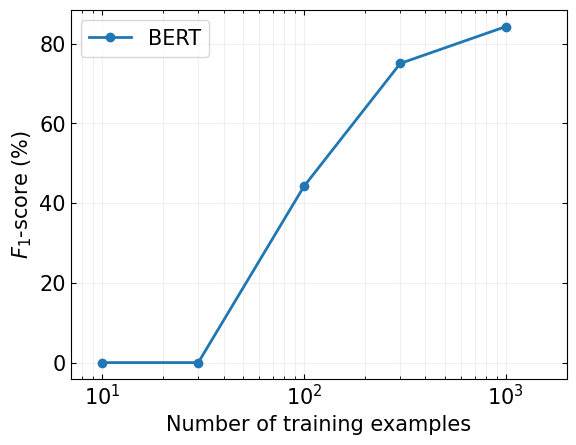

In [ ]:
# plot F1 score as a function of training samples

plt.plot(training_samples, np.dot(F1_scores,100), 'o-', lw=2, label='BERT')
plt.ylabel(r'$F_1$-score (%)', fontsize=15)
plt.xlabel('Number of training examples', fontsize=15)
plt.grid(which='both',alpha=0.2)
plt.xlim(7,2000)

plt.legend(fontsize=15)
plt.xscale('log')
plt.tick_params(top = 1 , right = 1, which = 'both', direction = 'in', labelsize = 15)
plt.savefig('ner_F1.pdf', dpi=9600, bbox_inches = 'tight')
files.download('ner_F1.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

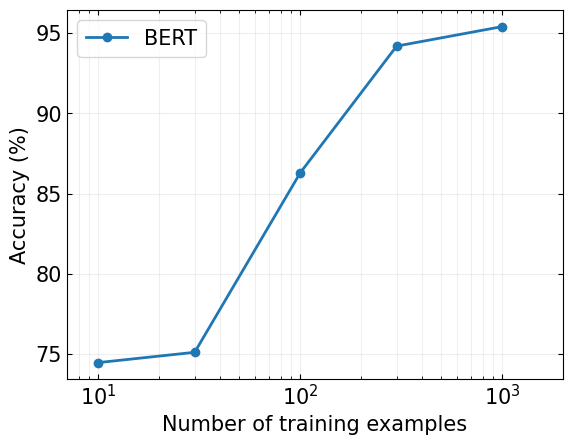

In [ ]:
# plot accuracy as a function of training samples

plt.plot(training_samples, np.dot(accuracy_scores,100), 'o-', lw=2, label='BERT')
plt.ylabel('Accuracy (%)',fontsize=15)
plt.xlabel('Number of training examples',fontsize=15)
plt.grid(which='both',alpha=0.2)
plt.xlim(7,2000)

plt.legend(fontsize=15)
plt.xscale('log')
plt.tick_params(top = 1 , right = 1, which = 'both', direction = 'in', labelsize = 15)
plt.savefig('ner_accuracy.pdf', dpi=9600, bbox_inches = 'tight')
files.download('ner_accuracy.pdf')